In [1]:
import mpramnist
from mpramnist.suredataset import SureDataset
from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import pyfastx
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

from collections import OrderedDict
from tltorch import TRL
import torchmtl
from rotary_embedding_torch import RotaryEmbedding

import boda

In [2]:
BATCH_SIZE = 20
NUM_WORKERS = 103

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torch.nn.utils.rnn import pad_sequence

# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5),
])
test_transform = t.Compose([ # трансформы теста слегка другие
    t.Seq2Tensor(), 
])

def pad_collate(batch):
    (seq, targets) = zip(*batch)

    seq = pad_sequence(seq, batch_first=True, padding_value=0.25)

    return seq, torch.vstack(targets)

task = "classification"

genome_ids = ["SuRE42_HG02601",
             "SuRE43_GM18983",
             "SuRE44_HG01241",
             "SuRE45_HG03464"]

# load the data
train_dataset = SureDataset(task = task, genome_id = genome_ids[0], split="train", transform=train_transform)                                                                                              # for needed folds
val_dataset = SureDataset(task = task, genome_id = genome_ids[0], split="val", transform=test_transform) # use "val" for default validation set
test_dataset = SureDataset(task = task, genome_id = genome_ids[0], split="test", transform=test_transform) # use "test" for default test set

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, collate_fn=pad_collate)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, collate_fn=pad_collate)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, collate_fn=pad_collate)

In [4]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score

def calculate_auroc( y_score, y_true, n_classes):

    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    
    y_true = y_true.cpu().numpy()
    
    return roc_auc_score(
        y_true,
        y_score,
        multi_class="ovr",
        average="macro",
    )

def calculate_aupr(y_score, y_true, n_classes):
    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_pred = np.argmax(y_score, axis=1)
    y_true = y_true.cpu().numpy()
    
    plt.hist(y_pred, color = 'blue', edgecolor = 'black',
     bins = n_classes)
    plt.title('Histogram count of label')
    plt.xlabel('label')
    plt.ylabel('count')
    arr = []
    for i in range(n_classes):
        arr.append(y_pred.tolist().count(i))
    print(arr)
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')  
    print("Precision:", precision)
    print("Recall:", recall)

    accuracy = accuracy_score(y_true, y_pred)

    f1 = f1_score(y_true, y_pred, average='macro')
    
    print("Accuracy:", accuracy)
    print("F1-score:", f1)

    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
    return pr_auc
    
def roc_auc(seq_model, loader, n_classes = 10, figure = False):
    
    y_preds = trainer.predict(seq_model, dataloaders=loader)
    y_preds = torch.concat(y_preds)
    
    targets = []
    for i, batch in tqdm(enumerate(loader)):
        x, y = batch
        targets.append(y.squeeze().long())
    targets = torch.concat(targets)

    fpr, tpr, roc_auc = dict(), dict(), dict()

    auroc = calculate_auroc(y_preds[:,0:5], targets[:,0], 5) 
    aupr = calculate_aupr( y_preds[:,0:5], targets[:,0], 5) 
    print("Test AUROC_K562: %.4f"%(np.nanmean(auroc)))
    print("Test AUPR_K562 : %.4f"%(np.nanmean(aupr)))

    auroc = calculate_auroc(y_preds[:,5:10], targets[:,1], 5) 
    aupr = calculate_aupr( y_preds[:,5:10], targets[:,1], 5) 
    print("Test AUROC_HepG2: %.4f"%(np.nanmean(auroc)))
    print("Test AUPR_HepG2 : %.4f"%(np.nanmean(aupr)))
        

# LegNet

In [4]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []
        self.output_dim = output_dim
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

# MPRAnn

In [13]:
class MPRAnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=250, kernel_size=7, padding="valid")
        self.bn1 = nn.BatchNorm1d(250)
        self.conv2 = nn.Conv1d(in_channels=250, out_channels=250, kernel_size=8, padding="valid")
        self.bn2 = nn.BatchNorm1d(250)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.1)
        self.conv3 = nn.Conv1d(in_channels=250, out_channels=250, kernel_size=3, padding="valid")
        self.bn3 = nn.BatchNorm1d(250)
        self.conv4 = nn.Conv1d(in_channels=250, out_channels=100, kernel_size=2, padding="valid")
        self.bn4 = nn.BatchNorm1d(100)
        self.pool2 = nn.MaxPool1d(kernel_size=1, stride=1) # does nothing, idk why they even have this layer, but keeping it for consistency
        self.dropout2 = nn.Dropout(0.1)
        self.fc1 = nn.LazyLinear(300)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(300, 200)

        self.embed_dims = 200
        self.head = nn.Sequential(nn.Linear(self.embed_dims, 2),
                                 )

    def forward(self, seq):
        #seq = seq.permute(0, 2, 1)
        seq = self.conv1(seq)
        seq = F.relu(seq)
        seq = self.bn1(seq)
        seq = self.conv2(seq)
        seq = F.softmax(seq, dim=1)
        seq = self.bn2(seq)
        seq = self.pool1(seq)
        seq = self.dropout1(seq)
        seq = self.conv3(seq)
        seq = F.softmax(seq, dim=1)
        seq = self.bn3(seq)
        seq = self.conv4(seq)
        seq = F.softmax(seq, dim=1)
        seq = self.bn4(seq)
        seq = self.pool2(seq)
        seq = self.dropout2(seq)
        seq = seq.reshape((seq.shape[0], -1))
        seq = self.fc1(seq)
        seq = F.sigmoid(seq)
        seq = self.dropout3(seq)
        seq = self.fc2(seq)
        seq = F.sigmoid(seq)
        seq = self.head(seq)

        return seq

# Trainer

In [6]:
import pytorch_lightning as L
from torch.nn import functional as F
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch = 10, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        
        #self.model = MTLucifer()
        model_config = [
                                {
                                    'name': "Backbone",
                                    'layers': self.model,
                                    # No anchor_layer means this layer receives input directly
                                }
                            ]
        self.n_classes = out_ch
        self.loss = torch.nn.CrossEntropyLoss().cuda() # for classification
        self.lr = lr
        self.val_loss = []
        
        self.y_score_1 = []
        self.y_score_2 = []
        self.y_true_1 = []
        self.y_true_2 = []

        self.train_loss = []
        #self.train_pears = []
        self.train_auc = []
        self.train_aupr = []
        self.head = nn.Sequential(nn.Linear(self.model.embed_dims, self.model.embed_dims),
                                   nn.BatchNorm1d(self.model.embed_dims),
                                   nn.SiLU(),
                                   nn.Linear(self.model.embed_dims, out_ch))
        model_config.append({
                                'name': "model",
                                'layers': self.head,
                                'loss': self.loss,
                                'loss_weight': torch.tensor(1.0),
                                'anchor_layer': 'Backbone'
                            })
        self.model = torchmtl.MTLModel(model_config, output_tasks=["model"])
        
    def forward(self, x):
        return self.model(x)
    '''
    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.squeeze().long()
        #y = self.ohe_y(self.n_classes, y)
        loss = self.loss(y_hat, y)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    '''
    def training_step(self, batch, batch_nb):
        X, y = batch

        l_funcs = None
        l_weights = None
        
        y_hat, l_funcs, l_weights = self(X.squeeze(1))            
        pred = y_hat[0]
        
        y = y.long()

        std = torch.exp(l_weights[0])**(1/2)
        is_regression = int(task == "regression")
        coeff = 1 / ((is_regression+1)*(std**2))
        
        if task == "classification":
            s = 0
            loss = 0
            output_names = ["K562_bin", "HepG2_bin"]
            num_classes_per_output = [5, 5]
            for j, output in enumerate(output_names):
                num_outputs_for_this = num_classes_per_output[j]
                loss += coeff * l_funcs[0](pred[:, s:s+num_outputs_for_this], y[:, j]) + torch.log(std)
                s += num_outputs_for_this
        else:
            loss = coeff * l_funcs[0](pred, y) + torch.log(std)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    '''
    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        y_hat = self.model(x)
        y = y.squeeze().long()
        
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
        self.val_yhat.append(y_hat)
        self.val_y.append(y)
        
    '''
    def validation_step(self, batch, batch_idx):
        X, y = batch

        l_funcs = None
        l_weights = None
        
        y_hat, l_funcs, l_weights = self(X.squeeze(1))            
        pred = y_hat[0]
        
        y = y.long()

        std = torch.exp(l_weights[0])**(1/2)
        is_regression = int(task == "regression")
        coeff = 1 / ((is_regression+1)*(std**2))
        
        if task == "classification":
            s = 0
            loss = 0
            output_names = ["K562_bin", "HepG2_bin"]
            num_classes_per_output = [5, 5]
            for j, output in enumerate(output_names):
                num_outputs_for_this = num_classes_per_output[j]
                loss += coeff * l_funcs[0](pred[:, s:s+num_outputs_for_this], y[:, j]) + torch.log(std)
                s += num_outputs_for_this
        else:
            loss = coeff * l_funcs[0](pred, y) + torch.log(std)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
        self.y_score_1.append(pred[:, 0:5])
        self.y_score_2.append(pred[:, 5:10])
        self.y_true_1.append(y[:,0])
        self.y_true_2.append(y[:,1])
        
    def on_validation_epoch_end(self):
        
        if len(self.train_loss) != 0:
            val_loss = torch.stack(self.val_loss, dim = 0).mean()
            
            y_score = torch.concat(self.y_score_1, dim = 0)
            y_true = torch.concat(self.y_true_1, dim = 0)
            
            auroc1 = self.calculate_auroc(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            aupr1 = self.calculate_aupr(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            print("roc_auc_k562 ",auroc1)
            print("aupr_k562",aupr1)

            y_score = torch.concat(self.y_score_2, dim = 0)
            y_true = torch.concat(self.y_true_2, dim = 0)
            
            auroc2 = self.calculate_auroc(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            aupr2 = self.calculate_aupr(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            print("roc_auc_heph2 ",auroc2)
            print("aupr_hepg2",aupr2)
            train_loss = torch.stack(self.train_loss, dim = 0).mean()
        
            res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
            res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)

            res_str += ' {}: {:.5f} |'.format("val_auc_roc", np.mean([auroc1, auroc2]))
            res_str += ' {}: {:.5f} |'.format("val_auc_pr", np.mean([aupr1,aupr2]))

            res_str += ' {}: {:.5f} |'.format("train_loss", train_loss)
            
            border = '-'*len(res_str)
            print("\n".join(['',border, res_str, border,'']))
            self.val_loss.clear()

            self.y_score_1.clear()
            self.y_score_2.clear()
            self.y_true_1.clear()
            self.y_true_2.clear()
    
            self.train_loss.clear()

        return None

    '''
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        y = y.squeeze().long()
        
        loss = self.loss(y_hat, y)
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        '''
    def test_step(self, batch, _):
        X, y = batch

        l_funcs = None
        l_weights = None
        
        y_hat, l_funcs, l_weights = self(X.squeeze(1))            
        pred = y_hat[0]
        
        y = y.long()

        std = torch.exp(l_weights[0])**(1/2)
        is_regression = int(task == "regression")
        coeff = 1 / ((is_regression+1)*(std**2))
        
        if task == "classification":
            s = 0
            loss = 0
            output_names = ["K562_bin", "HepG2_bin"]
            num_classes_per_output = [5, 5]
            for j, output in enumerate(output_names):
                num_outputs_for_this = num_classes_per_output[j]
                loss += coeff * l_funcs[0](pred[:, s:s+num_outputs_for_this], y[:, j]) + torch.log(std)
                s += num_outputs_for_this
        else:
            loss = coeff * l_funcs[0](pred, y) + torch.log(std)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)

    def calculate_auroc(self, y_score, y_true, n_classes):

        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        
        y_true = y_true.cpu().numpy()
        
        return roc_auc_score(
            y_true,
            y_score,
            multi_class="ovr",
            average="macro",
        )

    def calculate_aupr(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_true = y_true.cpu().numpy()
    
        arr = []
        for i in range(n_classes):
            arr.append(y_pred.tolist().count(i))
        print(arr)
        
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')  
        print("Precision:", precision)
        print("Recall:", recall)

        accuracy = accuracy_score(y_true, y_pred)

        f1 = f1_score(y_true, y_pred, average='macro')
        
        print("Accuracy:", accuracy)
        print("F1-score:", f1)

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
        return pr_auc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):

        #### Malinois
        '''
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), 
                                     lr=self.lr, weight_decay=1e-4, 
                                     betas=(0.8661062881299633, 0.879223105336538), amsgrad=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                         T_0=4096)
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]
        '''
        #### LegNet
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]
        '''
        self.optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr, weight_decay=1e-2)
        
        return self.optimizer
        '''

# Train

In [7]:
seq_model = Seq1Model(in_ch = 4, out_ch = 10, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-02-19 17:09:21.335350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 17:09:21.349452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[9983, 3454, 50352, 294, 11900]
Precision: 0.25378471566875016
Recall: 0.2586692633894424
Accuracy: 0.2563731360962321
F1-score: 0.19986332451450278
roc_auc_k562  0.6105387267744014
aupr_k562 0.2763934706772607
[31294, 35179, 7966, 21, 1523]
Precision: 0.21315558648112196
Recall: 0.22503597270610634
Accuracy: 0.2362107313478015
F1-score: 0.16860526625614405
roc_auc_heph2  0.5659496825953891
aupr_hepg2 0.23737824844602615

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 2.26152 | val_auc_roc: 0.58824 | val_auc_pr: 0.25689 | train_loss: 2.10907 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[27269, 12648, 25476, 247, 8295]
Precision: 0.3379959096336961
Recall: 0.31960031187728777
Accuracy: 0.3210928518293095
F1-score: 0.27791541494116406
roc_auc_k562  0.6697687980057617
aupr_k562 0.32196020845131657
[28744, 23478, 7040, 1434, 13239]
Precision: 0.29028008606783634
Recall: 0.290276542633062
Accuracy: 0.29283830391560156
F1-score: 0.25086280153883134
roc_auc_heph2  0.6303518970635495
aupr_hepg2 0.28690995475323117

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 2.11300 | val_auc_roc: 0.65006 | val_auc_pr: 0.30444 | train_loss: 2.08171 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[29472, 14187, 23833, 153, 6290]
Precision: 0.34324148603343224
Recall: 0.32357581253265677
Accuracy: 0.3255968080070332
F1-score: 0.27862705511316455
roc_auc_k562  0.6720500462284104
aupr_k562 0.3240105128962372
[37462, 20274, 7077, 7, 9115]
Precision: 0.3498983667171937
Recall: 0.29374795248959173
Accuracy: 0.2968282951240955
F1-score: 0.23471184494693728
roc_auc_heph2  0.6367484286405711
aupr_hepg2 0.29033067963194636

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 2.11028 | val_auc_roc: 0.65440 | val_auc_pr: 0.30717 | train_loss: 2.06736 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[25179, 15426, 24342, 767, 8221]
Precision: 0.3467008972782805
Recall: 0.3349064850703783
Accuracy: 0.3365118009062014
F1-score: 0.29869674794291
roc_auc_k562  0.6859438211905703
aupr_k562 0.33725227838833594
[28663, 16026, 9909, 313, 19024]
Precision: 0.299507064645457
Recall: 0.3199127852577319
Accuracy: 0.3225535943734361
F1-score: 0.2746562953627968
roc_auc_heph2  0.6498672901721544
aupr_hepg2 0.30195639316270767

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 2.08752 | val_auc_roc: 0.66791 | val_auc_pr: 0.31960 | train_loss: 2.05518 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[29829, 13543, 23069, 574, 6920]
Precision: 0.3566675092685371
Recall: 0.3351559170013845
Accuracy: 0.3370663420572124
F1-score: 0.29215219513802493
roc_auc_k562  0.6885551823223555
aupr_k562 0.3405192608303834
[35929, 13848, 12281, 276, 11601]
Precision: 0.30493697900892675
Recall: 0.31917106620744157
Accuracy: 0.32216135794955025
F1-score: 0.26696826164852155
roc_auc_heph2  0.6574521665555441
aupr_hepg2 0.30842931430628645

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 2.08717 | val_auc_roc: 0.67300 | val_auc_pr: 0.32447 | train_loss: 2.04240 |
-----------------------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-02-19 13:08:45.813385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 13:08:45.827813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[47, 23334, 6, 72, 0, 397, 0, 0, 10748, 592, 751, 0, 8155, 61, 64, 10859, 5080, 4114, 0, 0, 221, 26, 3175, 3297, 2984]
Precision: 0.06686444829671098
Recall: 0.07342576795984902
Accuracy: 0.07270589189408377
F1-score: 0.04170760074942066


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


roc_auc  0.6526320869041062
aupr  0.06741457009807886

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 3.16944 | val_auc_roc: 0.65263 | val_auc_pr: 0.06741 | train_loss: 3.62026 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[4519, 7393, 1187, 20, 9733, 15680, 6, 467, 1230, 204, 5073, 0, 7393, 2474, 8711, 69, 4115, 918, 0, 0, 0, 2064, 2, 2677, 0]
Precision: 0.08092348633594464
Recall: 0.0846092710051318
Accuracy: 0.08476364374112395
F1-score: 0.05667022131752008


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


roc_auc  0.6829765581668349
aupr  0.07690546428252026

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 3.12505 | val_auc_roc: 0.68298 | val_auc_pr: 0.07691 | train_loss: 2.98506 |
-----------------------------------------------------------------------------------------------------------------



In [8]:
roc_auc(seq_model, test_loader, n_classes = 10)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [9]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 output_dim,
                 activation=nn.SiLU
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []
        self.output_dim = output_dim
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.embed_dims = out_ch * 2
        
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x= x.permute(0,2,1)
        #print(x.size())
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        
        return x

In [10]:
import pytorch_lightning as L
from torch.nn import functional as F
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize


def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch = 10, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        

        self.loss = torch.nn.CrossEntropyLoss().cuda() # for classification
        self.lr = lr
        self.val_loss = []
        
        self.y_score_1 = []
        self.y_score_2 = []
        self.y_true_1 = []
        self.y_true_2 = []
        self.n_classes = out_ch
        self.train_loss = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.long()

        loss = self.loss(y_hat[:, 0:5], y[:,0])
        loss += self.loss(y_hat[:, 5:10], y[:,1])
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat[:, 0:5], y[:,0])
        loss += self.loss(y_hat[:, 5:10], y[:,1])
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
        self.y_score_1.append(y_hat[:, 0:5])
        self.y_score_2.append(y_hat[:, 5:10])
        self.y_true_1.append(y[:,0])
        self.y_true_2.append(y[:,1])
        
    def on_validation_epoch_end(self):
        
        if len(self.train_loss) != 0:
            val_loss = torch.stack(self.val_loss, dim = 0).mean()
            
            y_score = torch.concat(self.y_score_1, dim = 0)
            y_true = torch.concat(self.y_true_1, dim = 0)
            
            auroc1 = self.calculate_auroc(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            aupr1 = self.calculate_aupr(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            print("roc_auc_k562 ",auroc1)
            print("aupr_k562",aupr1)

            y_score = torch.concat(self.y_score_2, dim = 0)
            y_true = torch.concat(self.y_true_2, dim = 0)
            
            auroc2 = self.calculate_auroc(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            aupr2 = self.calculate_aupr(y_score = y_score, y_true = y_true, n_classes = int(self.n_classes/2)) 
            print("roc_auc_heph2 ",auroc2)
            print("aupr_hepg2",aupr2)
            train_loss = torch.stack(self.train_loss, dim = 0).mean()
        
            res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
            res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)

            res_str += ' {}: {:.5f} |'.format("val_auc_roc", np.mean([auroc1, auroc2]))
            res_str += ' {}: {:.5f} |'.format("val_auc_pr", np.mean([aupr1,aupr2]))

            res_str += ' {}: {:.5f} |'.format("train_loss", train_loss)
            
            border = '-'*len(res_str)
            print("\n".join(['',border, res_str, border,'']))
            self.val_loss.clear()

            self.y_score_1.clear()
            self.y_score_2.clear()
            self.y_true_1.clear()
            self.y_true_2.clear()
    
            self.train_loss.clear()

        return None

    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat[:, 0:5], y[:,0])
        loss += self.loss(y_hat[:, 5:10], y[:,1])
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)

    def calculate_auroc(self, y_score, y_true, n_classes):

        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        
        y_true = y_true.cpu().numpy()
        
        return roc_auc_score(
            y_true,
            y_score,
            multi_class="ovr",
            average="macro",
        )

    def calculate_aupr(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_true = y_true.cpu().numpy()
        
        arr = []
        for i in range(n_classes):
            arr.append(y_pred.tolist().count(i))
        print(arr)
        
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')  
        print("Precision:", precision)
        print("Recall:", recall)

        accuracy = accuracy_score(y_true, y_pred)

        f1 = f1_score(y_true, y_pred, average='macro')
        
        print("Accuracy:", accuracy)
        print("F1-score:", f1)

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
        return pr_auc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):

        #### Malinois
        '''
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), 
                                     lr=self.lr, weight_decay=1e-4, 
                                     betas=(0.8661062881299633, 0.879223105336538), amsgrad=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                         T_0=4096)
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]
        '''
        #### LegNet
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]
        '''
        self.optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr, weight_decay=1e-2)
        
        return self.optimizer
        '''
        

In [13]:
seq_model = Seq1Model(in_ch = 4, out_ch = 10, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | HumanLegNet      | 1.3 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.299     Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[15851, 26550, 27082, 1872, 4628, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.28337739432390385
Recall: 0.2905353641684906
Accuracy: 0.2941842254188437
F1-score: 0.2571984763553513
roc_auc_k562  0.6507437254712176
aupr_k562 0.3054984725557134
[35828, 17825, 18967, 0, 3363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.18883582095350615
Recall: 0.2594193859136753
Accuracy: 0.273337457062764
F1-score: 0.20342750505343604


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


roc_auc_heph2  0.6132182045366085
aupr_hepg2 0.27278590753423493

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 3.05998 | val_auc_roc: 0.63198 | val_auc_pr: 0.28914 | train_loss: 3.00018 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[37843, 11495, 18466, 0, 6131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.2633838327527165
Recall: 0.3038402306263016
Accuracy: 0.3057280043281261
F1-score: 0.2497643248522618
roc_auc_k562  0.6611820028214703
aupr_k562 0.3136674069790099
[43672, 13791, 9457, 0, 7015, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.23133118732456834
Recall: 0.2838642655196787
Accuracy: 0.28690065598160547
F1-score: 0.221320822244635


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


roc_auc_heph2  0.6246537048552774
aupr_hepg2 0.28059885363541154

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 3.07242 | val_auc_roc: 0.64292 | val_auc_pr: 0.29713 | train_loss: 2.93753 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[31396, 15900, 20403, 270, 5966, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.34364357862521866
Recall: 0.3201172752053901
Accuracy: 0.32221545952525865
F1-score: 0.2742969605746767
roc_auc_k562  0.6732755600096897
aupr_k562 0.326006278366223
[33244, 19195, 10825, 0, 10671, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.24122207223615186
Recall: 0.30282476575841866
Accuracy: 0.30582268208561575
F1-score: 0.2532531530556638
roc_auc_heph2  0.6468190635512647
aupr_hepg2 0.2994624235697309


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



-----------------------------------------------------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 3.00431 | val_auc_roc: 0.66005 | val_auc_pr: 0.31273 | train_loss: 2.90179 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[34843, 9268, 21948, 40, 7836, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.34349535654381624
Recall: 0.33407040560512347
Accuracy: 0.3357814296341381
F1-score: 0.2795758436000741
roc_auc_k562  0.6851166198219232
aupr_k562 0.33786564004278574
[37028, 12520, 10343, 55, 13989, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.2886431732640359
Recall: 0.3176557332927371
Accuracy: 0.3205788868600798
F1-score: 0.2602478935776846
roc_auc_heph2  0.6515745095554422
aupr_hepg2 0.3014313212975178

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 2.97000 | val_auc_roc: 0.66835 | val_auc_pr: 0.31965 | train_loss: 2.86974 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[29667, 14073, 22527, 463, 7205, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.3553660291928126
Recall: 0.3363592524045703
Accuracy: 0.3382295259349429
F1-score: 0.2932782564735091
roc_auc_k562  0.6881306276346953
aupr_k562 0.33976861348385745
[36710, 14475, 12169, 305, 10276, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Precision: 0.30384744315827905
Recall: 0.31621668133906145
Accuracy: 0.3192804490430784
F1-score: 0.2626307400262559
roc_auc_heph2  0.6575836352548553
aupr_hepg2 0.30787583222821435

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 2.95557 | val_auc_roc: 0.67286 | val_auc_pr: 0.32382 | train_loss: 2.83458 |
-----------------------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=5` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

73it [00:01, 53.07it/s]


[29246, 14012, 22093, 476, 8120]
Precision: 0.33826702486341265
Recall: 0.3268772241655347
Accuracy: 0.32837031928272953
F1-score: 0.28690354631092785
Test AUROC_K562: 0.6812
Test AUPR_K562 : 0.3361
[35931, 14704, 11360, 345, 11607]
Precision: 0.32340299851380594
Recall: 0.3281350036833082
Accuracy: 0.3310749590923229
F1-score: 0.27867898008236647
Test AUROC_HepG2: 0.6558
Test AUPR_HepG2 : 0.3146


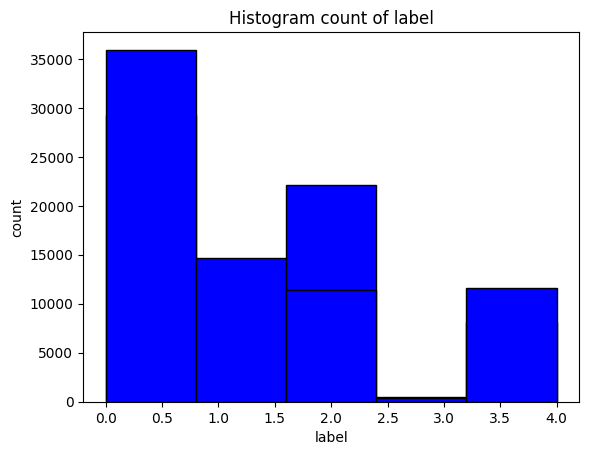

In [14]:
roc_auc(seq_model, test_loader, n_classes = 10)

# MTLucifer

In [14]:
import einops
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding="same", dilation=1, bias=True, gn_num_groups=None, gn_group_size=16):
        super().__init__()
        self.cnn = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, \
                             stride=stride, padding=padding, dilation=dilation, bias=bias)
        if gn_num_groups is None:
            gn_num_groups = out_channels // gn_group_size
        self.gn = nn.GroupNorm(gn_num_groups, out_channels)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, inputs):
        seq = inputs
        x = self.gn(F.gelu(self.cnn(seq)))
        x = self.dropout(x)
        
        return x
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn_num_groups=None, gn_group_size=16):
        super().__init__()

        stride_for_conv1_and_shortcut = 1

        if in_channels != out_channels:
            stride_for_conv1_and_shortcut = 2

        padding = kernel_size // 2

        if gn_num_groups is None:
            gn_num_groups = out_channels // gn_group_size

        # modules for processing the input
        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride_for_conv1_and_shortcut, padding = padding, bias=False)
        self.gn1 = nn.GroupNorm(gn_num_groups, out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = "same", bias=False)
        self.gn2 = nn.GroupNorm(gn_num_groups, out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        # short cut connections
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride = stride_for_conv1_and_shortcut, bias=False)

    def forward(self, xl):
        input = self.shortcut(xl)

        xl = self.relu1(self.gn1(self.conv1(xl)))
        xl = self.conv2(xl)

        xlp1 = input + xl

        xlp1 = self.relu2(self.gn2(xlp1))

        return xlp1
    
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, mlp_dim, dropout=0.1, use_position_embedding=True):
        assert d_model % nhead == 0
        super().__init__()
        embedding_dim = d_model
        self.embedding_dim = embedding_dim
        self.num_heads = nhead
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.use_position_embedding = use_position_embedding

        self.layer_norm1 = nn.LayerNorm(self.embedding_dim)
        self.xk = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.xq = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.xv = nn.Linear(embedding_dim, embedding_dim, bias=False)

        if self.use_position_embedding:
            self.rotary_emb = RotaryEmbedding(dim=embedding_dim // self.num_heads)

        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(self.embedding_dim)
        self.fc2 = nn.Linear(embedding_dim, mlp_dim)
        self.fc3 = nn.Linear(mlp_dim, embedding_dim)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, inputs):
        x = self.layer_norm1(inputs)
        xk = self.xk(x)
        xq = self.xq(x)
        xv = self.xv(x)

        xk = xk.reshape(xk.shape[0], xk.shape[1], self.num_heads, self.embedding_dim // self.num_heads)
        xq = xq.reshape(xq.shape[0], xq.shape[1], self.num_heads, self.embedding_dim // self.num_heads)
        xv = xv.reshape(xv.shape[0], xv.shape[1], self.num_heads, self.embedding_dim // self.num_heads)

        if self.use_position_embedding:
            # make xq and xk have shape (batch_size, num_heads, seq_len, embedding_dim // num_heads)
            xq = xq.permute(0, 2, 1, 3)
            xk = xk.permute(0, 2, 1, 3)
            xq = self.rotary_emb.rotate_queries_or_keys(xq, seq_dim=2)
            xk = self.rotary_emb.rotate_queries_or_keys(xk, seq_dim=2)
            # make xq and xk have shape (batch_size, seq_len, num_heads, embedding_dim // num_heads)
            xq = xq.permute(0, 2, 1, 3)
            xk = xk.permute(0, 2, 1, 3)
        
        attention_weights = einops.einsum(xq, xk, '... q h d, ... k h d -> ... h q k')

        attention_weights = attention_weights / np.sqrt(self.embedding_dim // self.num_heads)
        attention_weights = F.softmax(attention_weights, dim=-1)
        attention_weights = self.dropout1(attention_weights)
        attention_output = einops.einsum(attention_weights, xv, '... h q k, ... k h d -> ... q h d')
        attention_output = einops.rearrange(attention_output, '... h d -> ... (h d)')
        attention_output = self.fc1(attention_output)
        attention_output = self.dropout2(attention_output)

        mlp_inputs = attention_output + inputs
        x = self.layer_norm2(mlp_inputs)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = x + mlp_inputs

        return x

class MTLucifer(nn.Module):
    def __init__(self, nucleotide_embed_dims=1024, nheads=8, mlp_dim_ratio=4):
        super().__init__()
        self.nheads = nheads
        self.cls_token_embedding = nn.Parameter(torch.normal(mean=0.0, std=0.02, size=(1, 1, nucleotide_embed_dims)))
        self.embed_dims = nucleotide_embed_dims
        self.nheads = nheads
        self.mlp_dim = nucleotide_embed_dims * mlp_dim_ratio
        
        self.promoter_cnn = nn.Sequential(
                                            CNNBlock(in_channels = 4, out_channels = 256, kernel_size = 5, stride = 1, bias=True),
                                            CNNBlock(in_channels = 256, out_channels = 512, kernel_size = 5, stride = 1, bias=True),
                                            CNNBlock(in_channels = 512, out_channels = nucleotide_embed_dims, kernel_size = 5, stride = 1, bias=True)
                                         )
        self.promoter_transformer = nn.Sequential(
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim)
                                        )
        
        self.head = nn.Sequential(nn.Linear(self.embed_dims, 2),
                                 )
                                 
        
    def forward(self, seq):
        seq = seq.permute(0, 2, 1)
        seq = self.promoter_cnn(seq)
        seq = seq.permute(0, 2, 1)
        seq = torch.hstack([self.cls_token_embedding.expand(seq.shape[0], -1, -1), seq])
        outs = self.promoter_transformer(seq)[:, 0]
        outs = self.head(outs)

        return outs

In [12]:
class MTLuciferWithResidualBlocks(nn.Module):
    def __init__(self, nucleotide_embed_dims=1024, nheads=8, mlp_dim_ratio=2):
        super().__init__()
        self.nheads = nheads
        self.cls_token_embedding = nn.Parameter(torch.normal(mean=0.0, std=0.02, size=(1, 1, nucleotide_embed_dims)))
        self.embed_dims = nucleotide_embed_dims
        self.nheads = nheads
        self.mlp_dim = nucleotide_embed_dims * mlp_dim_ratio
        
        self.promoter_cnn = nn.Sequential(
                                            CNNBlock(in_channels = 4, out_channels = 256, kernel_size = 20),
                                            ResidualBlock(in_channels = 256, out_channels = 256, kernel_size = 5),
                                            ResidualBlock(in_channels = 256, out_channels = 512, kernel_size = 5),
                                            ResidualBlock(in_channels = 512, out_channels = nucleotide_embed_dims, kernel_size = 5)
                                         )
        self.promoter_transformer = nn.Sequential(
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim),
                                            TransformerBlock(d_model=nucleotide_embed_dims, nhead=self.nheads, mlp_dim=self.mlp_dim)
                                        )
        self.head = nn.Sequential(nn.Linear(self.embed_dims, 25),
                                 )
        
    def forward(self, seq):
        seq = seq.permute(0, 2, 1)
        seq = self.promoter_cnn(seq)
        seq = seq.permute(0, 2, 1)
        seq = torch.hstack([self.cls_token_embedding.expand(seq.shape[0], -1, -1), seq])
        outs = self.promoter_transformer(seq)[:, 0]
        outs = self.head(outs)

        return outs

# Pearson

In [4]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []
        self.output_dim = output_dim
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.embed_dims =  out_ch * 2
        '''
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))
        '''
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        #x = self.head(x)
        x = x.squeeze(-1)
        return x

In [5]:
import pytorch_lightning as L
from torch.nn import functional as F

def pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0)) + 1e-10)
    return torch.mean(pearsons)
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch = 2, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
    
        self.loss = nn.MSELoss() 
        self.lr = lr
        self.val_loss = []
        self.val_pears = [[] for i in range(out_ch)]
        
        self.train_loss = []
        self.train_pears = []
        model_config = [
                                {
                                    'name': "Backbone",
                                    'layers': self.model,
                                    # No anchor_layer means this layer receives input directly
                                }
                            ]
        self.n_classes = out_ch
        self.output = out_ch
        self.head = nn.Sequential(nn.Linear(self.model.embed_dims, self.model.embed_dims),
                                   nn.BatchNorm1d(self.model.embed_dims),
                                   nn.SiLU(),
                                   nn.Linear(self.model.embed_dims, out_ch))
        model_config.append({
                                'name': "model",
                                'layers': self.head,
                                'loss': self.loss,
                                'loss_weight': torch.tensor(1.0),
                                'anchor_layer': 'Backbone'
                            })
        self.model = torchmtl.MTLModel(model_config, output_tasks=["model"])
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch

        l_funcs = None
        l_weights = None
        
        y_hat, l_funcs, l_weights = self(X.squeeze(1))            
        pred = y_hat[0]
        
        y = y

        std = torch.exp(l_weights[0])**(1/2)
        is_regression = int(task == "regression")
        coeff = 1 / ((is_regression+1)*(std**2))
        
        if task == "classification":
            s = 0
            loss = 0
            output_names = ["K562_bin", "HepG2_bin"]
            num_classes_per_output = [5, 5]
            for j, output in enumerate(output_names):
                num_outputs_for_this = num_classes_per_output[j]
                loss += coeff * l_funcs[0](pred[:, s:s+num_outputs_for_this], y[:, j]) + torch.log(std)
                s += num_outputs_for_this
        else:
            loss = coeff * l_funcs[0](pred, y) + torch.log(std)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)

        corr = pearson_correlation(pred, y)
        self.train_pears.append(corr)
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        X, y = batch

        l_funcs = None
        l_weights = None
        
        y_hat, l_funcs, l_weights = self(X.squeeze(1))            
        pred = y_hat[0]
        
        y = y

        std = torch.exp(l_weights[0])**(1/2)
        is_regression = int(task == "regression")
        coeff = 1 / ((is_regression+1)*(std**2))
        
        if task == "classification":
            s = 0
            loss = 0
            output_names = ["K562_bin", "HepG2_bin"]
            num_classes_per_output = [5, 5]
            for j, output in enumerate(output_names):
                num_outputs_for_this = num_classes_per_output[j]
                loss += coeff * l_funcs[0](pred[:, s:s+num_outputs_for_this], y[:, j]) + torch.log(std)
                s += num_outputs_for_this
        else:
            loss = coeff * l_funcs[0](pred, y) + torch.log(std)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
        for i in range(y.shape[-1]):
            corr = pearson_correlation(pred[:,i], y[:,i])
            self.val_pears[i].append(corr)
        self.log(f"val_pearson", pearson_correlation(pred, y), on_epoch=True, prog_bar=True, on_step = False)
        
    def on_validation_epoch_end(self):
        
        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        #val_pears = torch.stack(self.val_pears, dim = 0).mean()
        val_pears = []
        if len(self.train_loss) != 0:
            train_loss = torch.stack(self.train_loss, dim = 0).mean()
            train_pears = torch.stack(self.train_pears, dim = 0).mean()
            
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        #res_str += ' {}: {:.5f} |'.format("val_pearson", val_pears)
        for i in range(self.output):
            res_str += '{}: {:.5f} |'.format(f"val_p_{i}", torch.tensor(self.val_pears[i]).mean())
            val_pears.append(torch.tensor(self.val_pears[i]).mean())
        if len(self.train_loss) != 0:
            res_str += '\n {}: {:.5f} |'.format("train_loss", train_loss)
            res_str += ' {}: {:.5f} |'.format("train_pearson", train_pears)
            res_str += ' {}: {:.5f} |'.format("val_pearson", torch.tensor(val_pears).mean())
            
        border = '-'*len(res_str)
        print("\n".join(['', border, res_str, border, '']))

        self.val_loss.clear()
        #self.val_pears.clear()
        self.val_pears = [[] for i in range(self.output)]
        if len(self.train_loss) != 0:
            self.train_loss.clear()
            self.train_pears.clear()
        return None

    def test_step(self, batch, _):
        X, y = batch

        l_funcs = None
        l_weights = None
        
        y_hat, l_funcs, l_weights = self(X.squeeze(1))            
        pred = y_hat[0]
        
        y = y

        std = torch.exp(l_weights[0])**(1/2)
        is_regression = int(task == "regression")
        coeff = 1 / ((is_regression+1)*(std**2))
        
        if task == "classification":
            s = 0
            loss = 0
            output_names = ["K562_bin", "HepG2_bin"]
            num_classes_per_output = [5, 5]
            for j, output in enumerate(output_names):
                num_outputs_for_this = num_classes_per_output[j]
                loss += coeff * l_funcs[0](pred[:, s:s+num_outputs_for_this], y[:, j]) + torch.log(std)
                s += num_outputs_for_this
        else:
            loss = coeff * l_funcs[0](pred, y) + torch.log(std)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        corr = pearson_correlation(pred, y)
        self.log("test_pearson", 
                 corr ,
                 on_epoch=True,
                 prog_bar=True,
                 on_step=False,)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):

        #### LegNet
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]
        

In [6]:
target_transform = t_t.Compose([])
task = "regression"
train_dataset = SureDataset(task = task, genome_id = genome_ids[0], split="train", transform=train_transform, target_transform = target_transform)                                                               # for needed folds
val_dataset = SureDataset(task = task, genome_id = genome_ids[0], split="val", transform=test_transform, target_transform = target_transform) # use "val" for default validation set
test_dataset = SureDataset(task = task, genome_id = genome_ids[0], split="test", transform=test_transform, target_transform = target_transform) # use "test" for default test set

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, collate_fn=pad_collate)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, collate_fn=pad_collate)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, collate_fn=pad_collate)

In [7]:
print(train_dataset)
print("#############################")
print(val_dataset)
print("#############################")
print(test_dataset)

Dataset SureDataset of size 619051 (MpraDaraset)
    Number of datapoints: 619051
    Default split folds: {}
    Used split fold: train
    Scalar features: {}
    Vector features: {}
    Cell types: ['SuRE42_HG02601', 'SuRE43_GM18983', 'SuRE44_HG01241', 'SuRE45_HG03464']
    Сell type used: SuRE42_HG02601
    Target columns that can be used: {}
    Sequence size: 196
    Number of samples: {}
#############################
Dataset SureDataset of size 73935 (MpraDaraset)
    Number of datapoints: 73935
    Default split folds: {}
    Used split fold: val
    Scalar features: {}
    Vector features: {}
    Cell types: ['SuRE42_HG02601', 'SuRE43_GM18983', 'SuRE44_HG01241', 'SuRE45_HG03464']
    Сell type used: SuRE42_HG02601
    Target columns that can be used: {}
    Sequence size: 361
    Number of samples: {}
#############################
Dataset SureDataset of size 73947 (MpraDaraset)
    Number of datapoints: 73947
    Default split folds: {}
    Used split fold: test
    Scalar fea

In [12]:
seq_model = Seq1Model(in_ch = 4, out_ch = 2, lr = 1e-5)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-06 17:50:00.077106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 17:50:00.186706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                                | 0/? [00:00…


----------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.00000 |val_p_0: 0.00000 |val_p_1: 0.00000 |
----------------------------------------------------------------------------------



Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


-------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 637.44934 |val_p_0: 0.06495 |val_p_1: 0.02813 |
 train_loss: 582.86108 | train_pearson: 0.23312 | val_pearson: 0.04654 |
-------------------------------------------------------------------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     662.7203369140625     │
│       test_pearson        │    0.04508490115404129    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 662.7203369140625, 'test_pearson': 0.04508490115404129}]

In [18]:
seq_model = Seq1Model(in_ch = 4, out_ch = 2, lr = 1e-5)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | MTLucifer | 66.3 M | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
66.3 M    Trainable params
320       Non-trainable params
66.3 M    Total params
265.005   Total estimated model params size (MB)
83        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…


----------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.10449 |val_p_0: 0.00000 |val_p_1: 0.00000 |
----------------------------------------------------------------------------------



Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


-------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 474.64417 |val_p_0: 0.09712 |val_p_1: 0.05490 |
 train_loss: 423.12463 | train_pearson: 0.31842 | val_pearson: 0.07601 |
-------------------------------------------------------------------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     495.1138610839844     │
│       test_pearson        │    0.07997729629278183    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 495.1138610839844, 'test_pearson': 0.07997729629278183}]

In [8]:
seq_model = Seq1Model(in_ch = 4, out_ch = 2, lr = 1e-5)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-06 20:58:13.295106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 20:58:13.308453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                                | 0/? [00:00…


----------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.50031 |val_p_0: 0.00000 |val_p_1: 0.00000 |
----------------------------------------------------------------------------------



Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


-------------------------------------------------------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 111.68809 |val_p_0: 0.07253 |val_p_1: 0.03070 |
 train_loss: 105.24991 | train_pearson: 0.24305 | val_pearson: 0.05162 |
-------------------------------------------------------------------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    115.96904754638672     │
│       test_pearson        │   0.051520854234695435    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 115.96904754638672, 'test_pearson': 0.051520854234695435}]